In [1]:

import numpy as np
import matplotlib.pyplot as plt
import h5py

import PSID
from PSID.evaluation import evalPrediction
# from PSID.MatHelper import loadmat

def eval_model(data,predictions,mask=None):
  if mask is None:
    mask = np.ones(data['valid_behavior'][:].shape[0],dtype=bool)

  # PSID_R2 = evalPrediction(data['valid_behavior'][:][mask].reshape((-1,2)), predictions[mask].reshape(-1,2), 'R2').mean()

  directions = data['valid_target_direction']
  unique_dirs = sorted(set(directions))

  R2 = np.empty((len(unique_dirs))) # directions
  for i,d in enumerate(unique_dirs):
    precision_error = (predictions[mask & (directions==d)] - data['valid_behavior'][:][mask & (directions==d)])**2
    total_variance = (data['valid_behavior'][:][mask & (directions==d)] - data['valid_behavior'][:][mask & (directions==d)].mean(0))**2+1e-6
    R2[i] = 1 - precision_error.sum()/total_variance.sum() # sum over trials and time and space
  R_UIVE = R2.mean() #uninstructed variance explained

  precision_error = (predictions[mask] - data['valid_behavior'][:][mask])**2
  total_variance = (data['valid_behavior'][:][mask] - data['valid_behavior'][:][mask].mean(0))**2
  vec_R2 = 1 - precision_error.sum()/total_variance.sum() # sum over trials and time and space
  return vec_R2,R_UIVE

In [2]:
data = h5py.File("../datasets/Chewie_CO_FF_2016-10-07_session_vel_M1_spikes_go.h5", "r")
print(data.keys())
print(data["valid_recon_data"].shape)

<KeysViewHDF5 ['train_behavior', 'train_encod_data', 'train_epoch', 'train_inds', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_encod_data', 'valid_epoch', 'valid_inds', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
(116, 101, 70)


In [3]:
np.arange(10)[None]

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [4]:
# PSID(neural, behaviour, latents dimensions,
# latent states to extract in the first stage,
# future and past horizon)

# run here with 40 dim, where there are some oscillations
n_factors = 40
n_beh_factors = 20
# mask = np.ones_like(data['train_epoch'],dtype=bool) # train on all epochs
mask = data['train_epoch'][:] == 1 # train on the AD epoch only
model = PSID.PSID(
    [d for d in data["train_recon_data"][mask]], [d for d in data["train_behavior"][mask]], 
    n_factors, n_beh_factors, 10
)

# max_lag=10
# min_lag=5
# aug_train_behavior = [data["train_behavior"][mask][:,min_lag+lag:-max_lag+lag] for lag in range(-min_lag,max_lag)] + [data["train_behavior"][mask][:,min_lag+max_lag:]]
# aug_train_behavior = np.concatenate(aug_train_behavior,axis=-1)
# print(aug_train_behavior.shape)

# # run here with 40 dim, where there are some oscillations
# n_factors = 40
# n_beh_factors = 20
# # mask = np.ones_like(data['train_epoch'],dtype=bool) # train on all epochs
# mask = data['train_epoch'][:] == 1 # train on the AD epoch only
# model = PSID.PSID(
#     [d for d in data["train_recon_data"][mask][:,min_lag:-max_lag]], [d for d in aug_train_behavior], 
#     n_factors, n_beh_factors, 10
# )

In [5]:
#predict factors
train_predictions = []
for trial in range(data['train_recon_data'].shape[0]):
    train_predictions.append(model.predict(data['train_recon_data'][trial])[2])

train_predictions = np.array(train_predictions)

predictions = []
for trial in range(data['valid_recon_data'].shape[0]):
    predictions.append(model.predict(data['valid_recon_data'][trial])[2])

predictions = np.array(predictions)

# train ridge regression to predict behavior from factors
from sklearn.linear_model import Ridge
X_train = train_predictions.reshape(-1,train_predictions.shape[-1])
Y_train = data['train_behavior'][:].reshape(-1,data['train_behavior'].shape[-1])
X_test = predictions.reshape(-1,predictions.shape[-1])
ridge = Ridge(alpha=1).fit(X_train, Y_train)
Y_pred = ridge.predict(X_test).reshape(data['valid_behavior'].shape)

X_train = train_predictions[...,:n_beh_factors].reshape(-1,n_beh_factors)
Y_train = data['train_behavior'][:].reshape(-1,data['train_behavior'].shape[-1])
X_test = predictions[...,:n_beh_factors].reshape(-1,n_beh_factors)
rel_ridge = Ridge(alpha=1).fit(X_train, Y_train)
rel_Y_pred = rel_ridge.predict(X_test).reshape(data['valid_behavior'].shape)

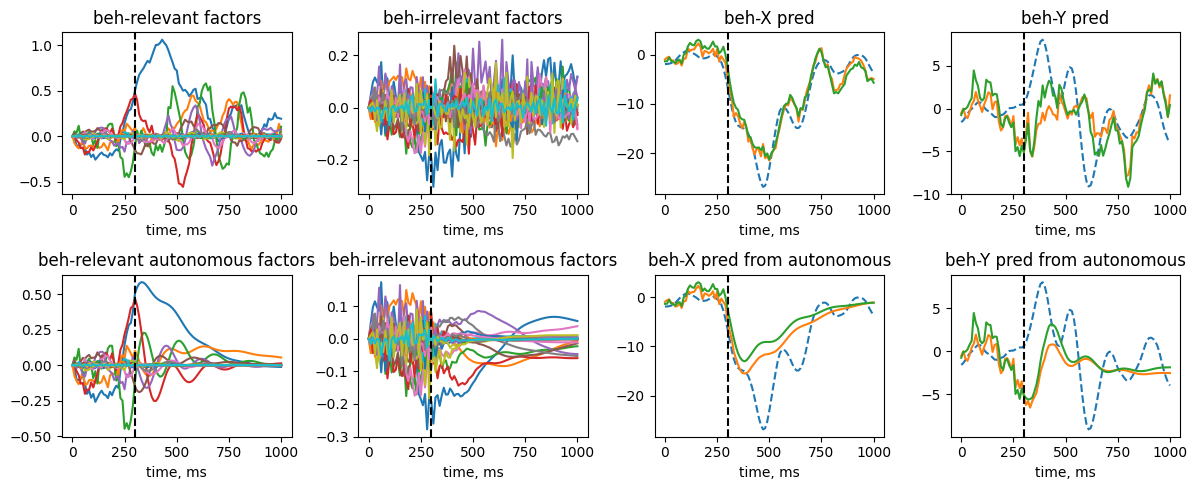

In [6]:

fig, axes = plt.subplots(2,4, figsize=(12,5))
trial = 5
axes[0,0].set_title('beh-relevant factors')
axes[0,0].plot(predictions[trial,:,:n_beh_factors])
axes[0,1].set_title('beh-irrelevant factors')
axes[0,1].plot(predictions[trial,:,n_beh_factors:])
axes[0,2].set_title('beh-X pred')
axes[0,2].plot(data['valid_behavior'][trial,:,0],linestyle='--')
axes[0,2].plot(Y_pred[trial,:,0])
axes[0,2].plot(rel_Y_pred[trial,:,0])
axes[0,3].set_title('beh-Y pred')
axes[0,3].plot(data['valid_behavior'][trial,:,1],linestyle='--')
axes[0,3].plot(Y_pred[trial,:,1])
axes[0,3].plot(rel_Y_pred[trial,:,1])

st = 30
trajectories = np.zeros_like(predictions)
trajectories[:,st] = predictions[:,st]
for i in range(st+1, trajectories.shape[1]):
    trajectories[:,i] = (model.A @ trajectories[:,i-1].T).T # transposes deal with trial dimension, tested
trajectories[:,:st] = predictions[:,:st]
axes[1,0].set_title('beh-relevant autonomous factors')
axes[1,0].plot(trajectories[trial,:,:n_beh_factors])
axes[1,1].set_title('beh-irrelevant autonomous factors')
axes[1,1].plot(trajectories[trial,:,n_beh_factors:])

Y_autonomous_pred = ridge.predict(trajectories.reshape(-1,trajectories.shape[-1])).reshape(data['valid_behavior'].shape)
rel_Y_autonomous_pred = rel_ridge.predict(trajectories[...,:n_beh_factors].reshape(-1,n_beh_factors)).reshape(data['valid_behavior'].shape)
axes[1,2].set_title('beh-X pred from autonomous')
axes[1,2].plot(data['valid_behavior'][trial,:,0],linestyle='--')
axes[1,2].plot(Y_autonomous_pred[trial,:,0])
axes[1,2].plot(rel_Y_autonomous_pred[trial,:,0])
axes[1,3].set_title('beh-Y pred from autonomous')
axes[1,3].plot(data['valid_behavior'][trial,:,1],linestyle='--')
axes[1,3].plot(Y_autonomous_pred[trial,:,1])
axes[1,3].plot(rel_Y_autonomous_pred[trial,:,1])

for ax in axes.flatten():
    ax.axvline(st, color='k', linestyle='--')
    ax.set_xlabel('time, ms')
    ax.set_xticks([0,25,50,75,100])
    ax.set_xticklabels([0,250,500,750,1000])

plt.tight_layout()

144.87637041954613 0.04843657655744817 [-2.11470737e-17+0.00000000e+00j -5.20806972e-17+1.23660917e-16j
 -5.20806972e-17-1.23660917e-16j -2.55974307e-02+1.59380105e-02j
 -2.55974307e-02-1.59380105e-02j -8.54906165e-17+0.00000000e+00j
 -3.70005472e-02+2.05476605e-02j -3.70005472e-02-2.05476605e-02j
 -3.10755870e-02+2.96887717e-02j -3.10755870e-02-2.96887717e-02j
  1.69000288e-16-8.72488920e-17j  1.69000288e-16+8.72488920e-17j
 -4.64170281e-03+5.18456135e-03j -4.64170281e-03-5.18456135e-03j
  1.18410127e-16+0.00000000e+00j -1.56212475e-15-1.12367679e-15j
 -1.56212475e-15+1.12367679e-15j  1.41131582e-02-1.25158059e-02j
  1.41131582e-02+1.25158059e-02j -1.46717842e-02-1.92733728e-03j
 -1.46717842e-02+1.92733728e-03j -7.94920312e-17+0.00000000e+00j
 -4.29489875e-04+2.41509955e-04j -4.29489875e-04-2.41509955e-04j
 -3.35194306e-17+0.00000000e+00j  1.20813260e-03-1.20865777e-03j
  1.20813260e-03+1.20865777e-03j  1.03603251e-17+0.00000000e+00j
  4.46351188e-17+3.79488089e-17j  4.46351188e-17-3.

(-1.1, 1.1, -1.1, 1.1)

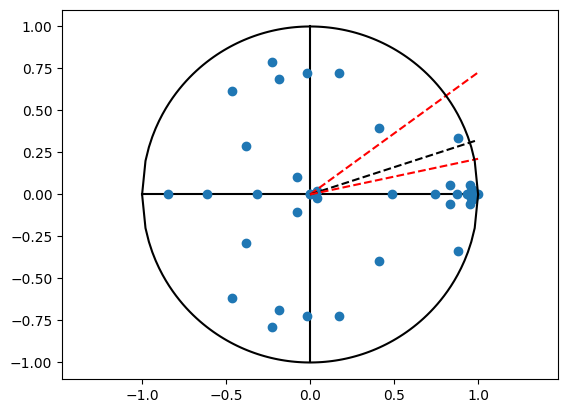

In [7]:
evals, evecs = np.linalg.eig(model.A)

plt.plot([-1,1],[0,0],'k')
plt.plot([0,0],[-1,1],'k')
plt.plot(evals.real,evals.imag,'o')
# for ev in evals:
#     plt.plot([0,ev.real],[0,ev.imag],'o')
# draw a line at 18 degrees
plt.plot([0,1],[0,np.tan(2 * 10 * np.pi/100)],'r--')
plt.plot([0,1],[0,np.tan(2 * 10 * np.pi/200)],'k--')
plt.plot([0,1],[0,np.tan(2 * 10 * np.pi/300)],'r--')
# draw a unit circle
x = np.linspace(-1,1,100)
y = np.sqrt(1-x**2)
plt.plot(x,y,'k')
y = -np.sqrt(1-x**2)
plt.plot(x,y,'k')

for eval, evec in zip(evals,evecs):
    a = np.angle(eval)
    if (a > 2 * 10 * np.pi/300) & (a < 2 * 10 * np.pi/100):
        T = 2 * 10 * np.pi / a
        amp = np.linalg.norm(eval)
        print(T,amp,evec)

plt.axis('equal')

In [8]:
# get angles of eigenvalues
angles = np.angle(evals)
distance_from_oscillatory = (angles - 2 * 10 * np.pi/200) % (2*np.pi)
which_eval = np.where((np.abs(distance_from_oscillatory) < 2 * 10 * np.pi/100) & (np.sqrt(evals.real**2 + evals.imag**2)>0.5))[0]

oscillatory_evec = evecs[which_eval].T
oscillatory_evec.shape

(40, 2)

In [9]:
from lfads_torch.metrics import r2_score

def lagged_r2s(x_train, x_test, true_train_beh, true_valid_beh, max_lag = 25):
    lags = np.arange(-max_lag,max_lag+1)
    r2s = []
    for lag in lags:
        # ridge regression between lagged factors and behavior
        if lag==max_lag:
            X_train = x_train[:,max_lag+lag:].reshape(-1,x_train.shape[-1])
            X_test = x_test[:,max_lag+lag:].reshape(-1,x_test.shape[-1])
        else:
            X_train = x_train[:,max_lag+lag:-max_lag+lag].reshape(-1,x_train.shape[-1])
            X_test = x_test[:,max_lag+lag:-max_lag+lag].reshape(-1,x_test.shape[-1])

        Y_train = true_train_beh[:,max_lag:-max_lag].reshape(-1,true_train_beh.shape[-1])
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred = ridge.predict(X_test).reshape(true_valid_beh[:,max_lag:-max_lag].shape)
        r2 = r2_score(Y_pred, true_valid_beh[:,max_lag:-max_lag])
        r2s.append(r2)
    return -lags*10, r2s

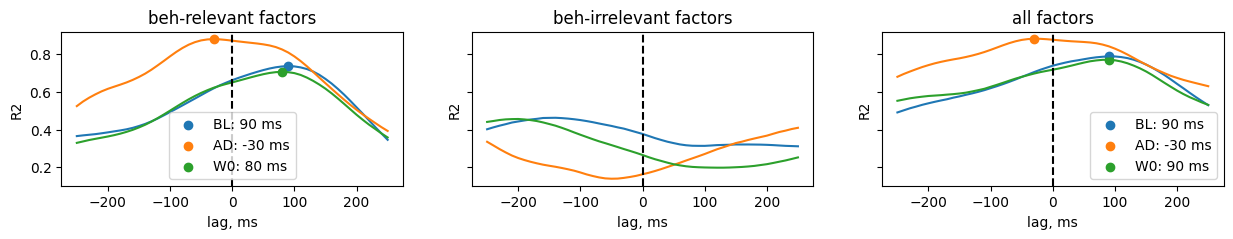

In [12]:
fig, axes = plt.subplots(1,3, figsize=(15,2),sharey=True)
for epoch, epoch_name in enumerate(['BL','AD','W0']):
   
   lag_r2 = lagged_r2s(train_predictions[:,:,:n_beh_factors][data['train_epoch'][:] == epoch],
                        predictions[:,:,:n_beh_factors][data['valid_epoch'][:] == epoch],
                        data['train_behavior'][:][data['train_epoch'][:] == epoch],
                        data['valid_behavior'][:][data['valid_epoch'][:] == epoch])
   axes[0].plot(*lag_r2)
   id_max = np.argmax(lag_r2[1])
   axes[0].scatter(lag_r2[0][id_max],lag_r2[1][id_max],label=f'{epoch_name}: {lag_r2[0][id_max]} ms')

   axes[1].plot(*lagged_r2s(train_predictions[:,:,n_beh_factors:][data['train_epoch'][:] == epoch],
                        predictions[:,:,n_beh_factors:][data['valid_epoch'][:] == epoch],
                        data['train_behavior'][:][data['train_epoch'][:] == epoch],
                        data['valid_behavior'][:][data['valid_epoch'][:] == epoch],), 
   )

#    axes[2].plot(*lagged_r2s((train_predictions[:]@oscillatory_evec.real)[data['train_epoch'][:] == epoch],
#                         (predictions[:]@oscillatory_evec.real)[data['valid_epoch'][:] == epoch],
#                         data['train_behavior'][:][data['train_epoch'][:] == epoch],
#                         data['valid_behavior'][:][data['valid_epoch'][:] == epoch]), 
#    )

   lag_r2 = lagged_r2s(train_predictions[:,:,:][data['train_epoch'][:] == epoch],
                        predictions[:,:,:][data['valid_epoch'][:] == epoch],
                        data['train_behavior'][:][data['train_epoch'][:] == epoch],
                        data['valid_behavior'][:][data['valid_epoch'][:] == epoch])
   axes[2].plot(*lag_r2)
   id_max = np.argmax(lag_r2[1])
   axes[2].scatter(lag_r2[0][id_max],lag_r2[1][id_max],label=f'{epoch_name}: {lag_r2[0][id_max]} ms')

for ax in axes:
      ax.set_xlabel('lag, ms')
      ax.set_ylabel('R2')
      ax.axvline(0, color='k', linestyle='--')
axes[0].set_title('beh-relevant factors')
axes[1].set_title('beh-irrelevant factors')
axes[2].set_title('all factors')
axes[0].legend()
axes[2].legend()

# Run models with various lags

100%|██████████| 51/51 [04:03<00:00,  4.77s/it]


Text(0.5, 1.0, 'beh-irrelevant factors')

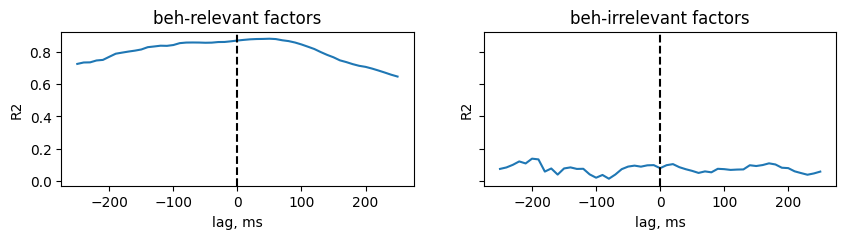

In [13]:
from tqdm import tqdm

def run_lagged_r2s(x_train, x_test, true_train_beh, true_valid_beh, max_lag = 25, n_factors = 40, n_beh_factors = 20):
    lags = np.arange(-max_lag,max_lag+1)
    rel_r2s, irrel_r2s = [], []
    for lag in tqdm(lags):

        neural = x_train[:,max_lag+lag:] if lag==max_lag else x_train[:,max_lag+lag:-max_lag+lag]
        neural_test = x_test[:,max_lag+lag:] if lag==max_lag else x_test[:,max_lag+lag:-max_lag+lag]
        behavioral = true_train_beh[:,max_lag:-max_lag]
        behavioral_test = true_valid_beh[:,max_lag:-max_lag]
        model = PSID.PSID(
            [d for d in neural], [d for d in behavioral], 
            n_factors, n_beh_factors, 10
        )
        #predict factors
        train_predictions = np.array([model.predict(a)[2] for a in neural])
        predictions = np.array([model.predict(a)[2] for a in neural_test])

        # ridge regression between lagged factors and behavior
        X_train = train_predictions[:,:,:n_beh_factors].reshape(-1,n_beh_factors)
        X_test = predictions[:,:,:n_beh_factors].reshape(-1,n_beh_factors)

        Y_train = behavioral.reshape(-1,true_train_beh.shape[-1])
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred = ridge.predict(X_test).reshape(behavioral_test.shape)
        r2 = r2_score(Y_pred, behavioral_test)
        rel_r2s.append(r2)

        # ridge regression between lagged factors and behavior
        X_train = train_predictions[:,:,n_beh_factors:].reshape(-1,n_factors - n_beh_factors)
        X_test = predictions[:,:,n_beh_factors:].reshape(-1,n_factors - n_beh_factors)

        Y_train = behavioral.reshape(-1,true_train_beh.shape[-1])
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred = ridge.predict(X_test).reshape(behavioral_test.shape)
        r2 = r2_score(Y_pred, behavioral_test)
        irrel_r2s.append(r2)
    return -lags*10, rel_r2s, irrel_r2s

lags2plot, rel_r2s, irrel_r2s = run_lagged_r2s(data["train_recon_data"][data['train_epoch'][:] == 1],
                                                data["valid_recon_data"][data['valid_epoch'][:] == 1],
                                                data["train_behavior"][data['train_epoch'][:] == 1],
                                                data["valid_behavior"][data['valid_epoch'][:] == 1],
                                                n_factors = 40, n_beh_factors = 20)

fig, axes = plt.subplots(1,2, figsize=(10,2),sharey=True)
axes[0].plot(lags2plot, rel_r2s)
axes[1].plot(lags2plot, irrel_r2s)
for ax in axes:
    ax.set_xlabel('lag, ms')
    ax.set_ylabel('R2')
    ax.axvline(0, color='k', linestyle='--')
axes[0].set_title('beh-relevant factors')
axes[1].set_title('beh-irrelevant factors')

In [15]:
lags2plot = [None, lags2plot, None]
rel_r2s = [None, rel_r2s, None]
irrel_r2s = [None, irrel_r2s, None]

In [16]:
for epoch in [0,2]:
    lags2plot[epoch], rel_r2s[epoch], irrel_r2s[epoch] = run_lagged_r2s(data["train_recon_data"][data['train_epoch'][:] == epoch],
                                                                        data["valid_recon_data"][data['valid_epoch'][:] == epoch],
                                                                        data["train_behavior"][data['train_epoch'][:] == epoch],
                                                                        data["valid_behavior"][data['valid_epoch'][:] == epoch],
                                                                        n_factors = 40, n_beh_factors = 20)

100%|██████████| 51/51 [04:11<00:00,  4.94s/it]


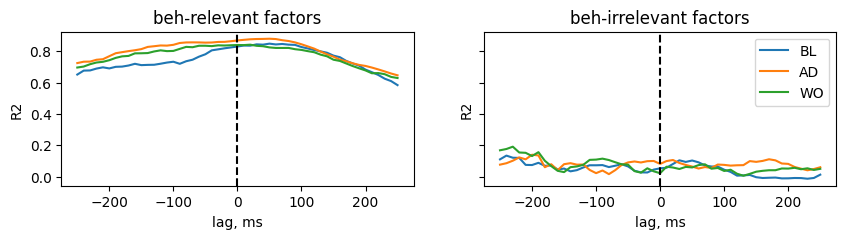

In [22]:
fig, axes = plt.subplots(1,2, figsize=(10,2),sharey=True)
for epoch in range(3):
    axes[0].plot(lags2plot[epoch], rel_r2s[epoch])
    axes[1].plot(lags2plot[epoch], irrel_r2s[epoch])
for ax in axes:
    ax.set_xlabel('lag, ms')
    ax.set_ylabel('R2')
    ax.axvline(0, color='k', linestyle='--')
    # ax.set_xlim([-100,100])
axes[0].set_title('beh-relevant factors')
axes[1].set_title('beh-irrelevant factors')
plt.legend(['BL','AD','WO'])

Text(0.5, 1.0, 'beh-irrelevant factors')

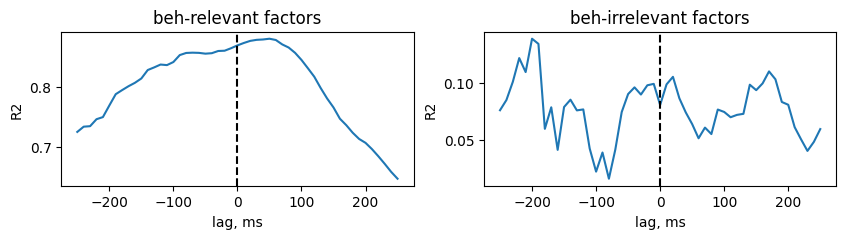

In [14]:
fig, axes = plt.subplots(1,2, figsize=(10,2))
axes[0].plot(lags2plot, rel_r2s)
axes[1].plot(lags2plot, irrel_r2s)
for ax in axes:
    ax.set_xlabel('lag, ms')
    ax.set_ylabel('R2')
    ax.axvline(0, color='k', linestyle='--')
axes[0].set_title('beh-relevant factors')
axes[1].set_title('beh-irrelevant factors')

In [153]:
data['valid_epoch'][:]

array([1, 1, 1, 0, 1, 1, 0, 2, 0, 0, 2, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 2,
       0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 1, 1, 0, 1, 0, 0, 0, 2, 2, 1, 2,
       1, 2, 1, 0, 1, 1, 1, 2, 2, 2, 1, 1, 0, 2, 2, 0, 2, 0, 2, 0, 1, 0,
       2, 2, 2, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 2, 2, 2, 2, 1, 1, 2, 2, 0,
       2, 1, 0, 1, 2, 0, 1, 1, 2, 2, 2, 1, 1, 0, 0, 2, 0, 2, 1, 1, 2, 0,
       0, 0, 0, 1, 2, 0])

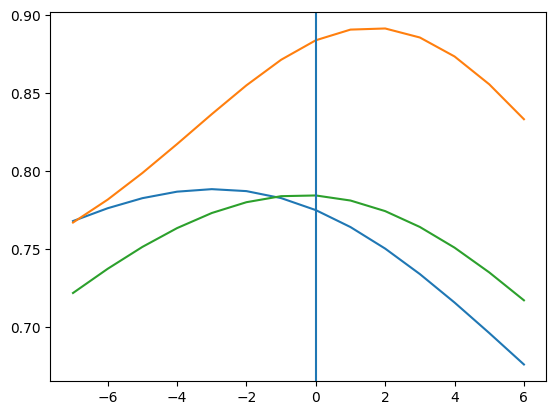

In [12]:
lags = range(-7,7)
for epoch in [0,1,2]:
    c = []
    for lag in lags:
        beh = np.roll(data['valid_behavior'],lag,axis=1)
        mask = data['valid_epoch'][:] == epoch
        c.append(np.corrcoef(beh[mask][:,st:].flatten(),Y_pred[mask][:,st:].flatten())[0,1])
    plt.plot(lags,c)
plt.axvline(0)

(0.5121726092512858,
 array([-2.77960309, -1.76279083, -1.13159024, -4.00543839, -1.29188967,
        -1.24317673, -4.48697225, -1.7073901 ]),
 -2.30110641381481)

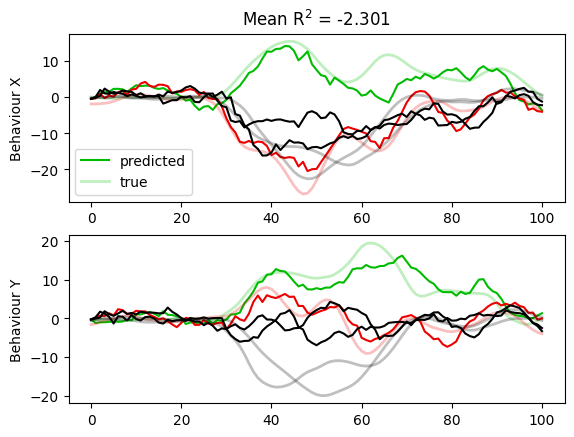

In [21]:
colors = plt.cm.nipy_spectral(np.arange(8)/8)

directions = data['valid_target_direction']
unique_dirs = sorted(set(directions))
direction_index = [unique_dirs.index(i) for i in directions]

predictions = []
for trial in range(data['valid_recon_data'].shape[0]):
    predictions.append(model.predict(data['valid_recon_data'][trial])[0])
predictions = np.array(predictions)

R2 = np.empty((len(unique_dirs))) # directions
for i,d in enumerate(unique_dirs):
  precision_error = (predictions[directions==d] - data['valid_behavior'][directions==d])**2
  total_variance = (data['valid_behavior'][:][directions==d] - data['valid_behavior'][directions==d].mean(0))**2+1e-6
  R2[i] = 1 - precision_error.sum()/total_variance.sum() # sum over trials and time and space

precision_error = (predictions - data['valid_behavior'][:])**2
total_variance = (data['valid_behavior'][:] - data['valid_behavior'][:].mean(0))**2+1e-6
R2_all = 1 - precision_error.sum()/total_variance.sum() # sum over trials and time and space

for trial in range(4,8):
    b = data['valid_behavior'][trial]
    p = predictions[trial]
    plt.subplot(2,1,1)
    plt.plot(p[:,0],'-', c=colors[direction_index[trial]], label='predicted')
    plt.plot(b[:,0], '-', c=colors[direction_index[trial]], alpha= 0.25, lw=2, label='true')
    plt.subplot(2,1,2)
    plt.plot(p[:,1],'-', c=colors[direction_index[trial]])
    plt.plot(b[:,1], '-', c=colors[direction_index[trial]], alpha= 0.25, lw=2) 
plt.subplot(2,1,1)
plt.ylabel('Behaviour X')
plt.title(f'Mean R$^2$ = {R2.mean():.3f}')
plt.legend(['predicted', 'true'])
plt.subplot(2,1,2)
plt.ylabel('Behaviour Y')
    
R2_all, R2, R2.mean()

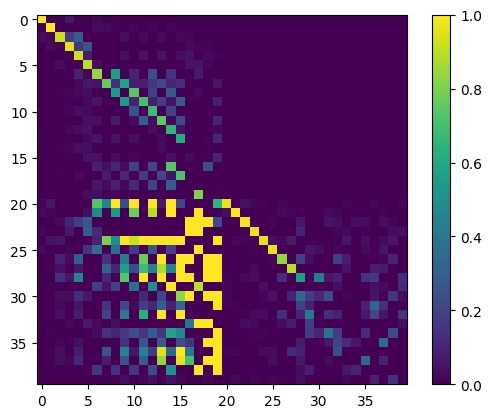

In [22]:
plt.imshow(model.A, vmin=0, vmax=1)
plt.colorbar()

174.5458436581343 0.9425632592875715 [-0.01204894-0.00143752j -0.01204894+0.00143752j  0.0141871 +0.01204485j
  0.0141871 -0.01204485j  0.00620254+0.j          0.01357242+0.j
  0.24876581+0.00670441j  0.24876581-0.00670441j  0.25693164-0.1938734j
  0.25693164+0.1938734j  -0.26165528+0.22271865j -0.26165528-0.22271865j
  0.18656916+0.04867705j  0.18656916-0.04867705j -0.02214514+0.00599381j
 -0.02214514-0.00599381j -0.28892358+0.21569984j -0.28892358-0.21569984j
  0.16870169-0.00380061j  0.16870169+0.00380061j  0.09437353+0.j
 -0.03875165+0.j         -0.08738851-0.01317841j -0.08738851+0.01317841j
  0.13419369-0.03466089j  0.13419369+0.03466089j -0.12015749+0.21463219j
 -0.12015749-0.21463219j -0.13399471+0.0328447j  -0.13399471-0.0328447j
  0.0612044 +0.01016086j  0.0612044 -0.01016086j -0.3020145 +0.11868288j
 -0.3020145 -0.11868288j -0.3454607 +0.j          0.11437098-0.00105838j
  0.11437098+0.00105838j  0.14845492+0.j         -0.30702837+0.j
 -0.08863332+0.j        ]


(-1.1, 1.1, -1.1, 1.1)

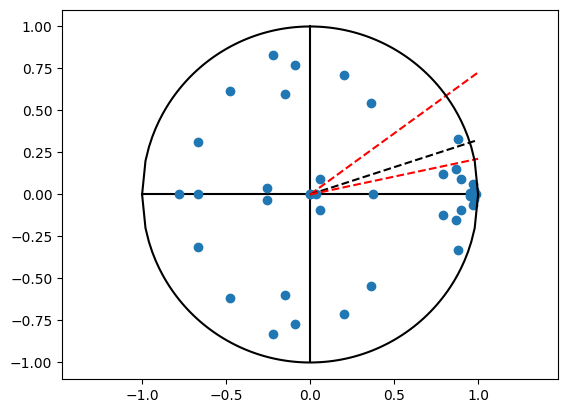

In [24]:
# Fs = [10,14,18,22,26,30,34,38,42]
Fs = [2,3,4,5,6,7,8,9]
eigenvalues = np.empty((len(Fs),4), dtype=object)
potentially_oscillatory_eigenvalues = np.empty((len(Fs),4), dtype=object)
for i, n_factors in enumerate(Fs):

    for j,n_beh_factors in enumerate([0]):

        if eigenvalues[i,j] is None:
            
            print('Running with', n_beh_factors, '/', n_factors, 'factors')
            mask = data['train_epoch'][:] == 1 # train on the AD epoch only
            model = PSID.PSID(
                [d for d in data["train_recon_data"][mask]], [d for d in data["train_behavior"][mask]], 
                n_factors, n_beh_factors, max(10, int(np.ceil(n_beh_factors/2)))
            )

            evals = np.linalg.eig(model.A)[0]

            interesting_evals = []
            for eval in evals:
                a = np.angle(eval)
                if (a > 2 * 10 * np.pi/300) & (a < 2 * 10 * np.pi/100):
                    T = 2 * 10 * np.pi / a
                    amp = np.linalg.norm(eval)
                    print(T,amp)
                    interesting_evals.append(eval)

            eigenvalues[i,j] = evals
            potentially_oscillatory_eigenvalues[i,j] = interesting_evals
        

Running with 0 / 2 factors


KeyboardInterrupt: 

In [ ]:
np.save('eigenvalues.npy', eigenvalues)
np.save('potentially_oscillatory_eigenvalues.npy', potentially_oscillatory_eigenvalues)

In [235]:
eigenvalues = np.load('eigenvalues.npy', allow_pickle=True)
potentially_oscillatory_eigenvalues = np.load('potentially_oscillatory_eigenvalues.npy', allow_pickle=True)


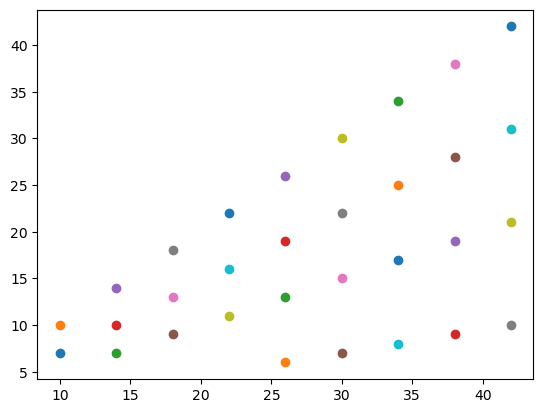

In [236]:
for i, n_factors in enumerate(Fs):

    for j,n_beh_factors in enumerate([n_factors//4, n_factors//2, (n_factors*3)//4, n_factors]):

        if len(potentially_oscillatory_eigenvalues[i,j])>0:
            plt.scatter(n_factors,n_beh_factors)